# Hidden Markov Models

In [1]:
import numpy as np

class HMM:
    def __init__(self,
                 states,           # lista de nombres de estados, e.g. ["Lluvia", "NoLluvia"]
                 observations,     # lista de posibles observaciones, e.g. ["Paraguas", "NoParaguas"]
                 start_prob,       # distribución inicial P(R_0)
                 transition_prob,  # matriz de transición P(R_t | R_{t-1})
                 emission_prob):   # matriz de emisión P(U_t | R_t)

        self.states = states
        self.observations = observations

        # Convertimos todo a arreglos de numpy
        self.start_prob = np.array(start_prob)           # shape = (num_states,)
        self.transition_prob = np.array(transition_prob) # shape = (num_states, num_states)
        self.emission_prob = np.array(emission_prob)     # shape = (num_states, num_observations)

        # Diccionarios para mapear nombres -> índices
        self.state_index = { state: i for i, state in enumerate(states) }
        self.obs_index = { obs: i for i, obs in enumerate(observations) }

    def forward(self, observed_sequence):
        """
        Dada una secuencia de observaciones (e.g. ["Paraguas", "Paraguas", "NoParaguas"]),
        calcula alpha_t(i) = P(U_1, U_2, ..., U_t, R_t = i)
        y retorna la distribución normalizada P(R_t | U_1,...,U_t) en cada paso t.
        """
        T = len(observed_sequence)
        N = len(self.states)

        # alpha[t, i] = P(U_1,...,U_t, R_t = i)
        alpha = np.zeros((T, N))

        # Inicialización (t = 0)
        first_obs = observed_sequence[0]
        first_obs_idx = self.obs_index[first_obs]

        for i in range(N):
            alpha[0, i] = self.start_prob[i] * self.emission_prob[i, first_obs_idx]

        # Normalización para el paso t=0
        alpha[0, :] = alpha[0, :] / np.sum(alpha[0, :])

        # Iteración para t > 0
        for t in range(1, T):
            obs = observed_sequence[t]
            obs_idx = self.obs_index[obs]

            for j in range(N):
                # Suma sobre todos los estados posibles en t-1
                alpha[t, j] = np.sum(alpha[t-1, :] * self.transition_prob[:, j]) * self.emission_prob[j, obs_idx]

            # Normalizamos para mantener valores numéricamente estables
            alpha[t, :] = alpha[t, :] / np.sum(alpha[t, :])

        return alpha

    def most_likely_states_viterbi(self, observed_sequence):
        """
        Implementación del algoritmo de Viterbi para hallar la secuencia
        de estados ocultos más probable dada la evidencia.
        Retorna la lista de estados (strings) que maximizan P(R_1,...,R_T | U_1,...,U_T).
        """
        T = len(observed_sequence)
        N = len(self.states)

        # delta[t, i] = max_{r1..r_{t-1}} P(r1..r_{t-1}, R_t = i, U_1..U_t)
        delta = np.zeros((T, N))
        # psi[t, i] = argmax_{r_{t-1}} (delta[t-1,r_{t-1}] * trans_prob[r_{t-1},i])
        psi = np.zeros((T, N), dtype=int)

        # Inicialización
        first_obs_idx = self.obs_index[observed_sequence[0]]
        for i in range(N):
            delta[0, i] = self.start_prob[i] * self.emission_prob[i, first_obs_idx]
            psi[0, i] = 0

        # Recursión
        for t in range(1, T):
            obs_idx = self.obs_index[observed_sequence[t]]
            for j in range(N):
                # Calculamos la mejor transición desde cada i
                prob_ij = delta[t-1, :] * self.transition_prob[:, j]
                psi[t, j] = np.argmax(prob_ij)
                delta[t, j] = np.max(prob_ij) * self.emission_prob[j, obs_idx]

        # Retroceso (backtracking) para encontrar la mejor secuencia
        states_sequence = np.zeros(T, dtype=int)
        states_sequence[T-1] = np.argmax(delta[T-1, :])

        for t in reversed(range(T-1)):
            states_sequence[t] = psi[t+1, states_sequence[t+1]]

        # Convertimos índices a nombres de estados
        best_path = [self.states[idx] for idx in states_sequence]
        return best_path


if __name__ == "__main__":
    # Definimos el conjunto de estados y observaciones
    estados = ["Lluvia", "NoLluvia"]
    observaciones = ["Paraguas", "NoParaguas"]

    # Probabilidades iniciales P(R_0)
    p_inicial = [0.5, 0.5]

    # Matriz de transición P(R_t | R_{t-1})
    #   [ P(Lluvia|Lluvia), P(NoLluvia|Lluvia) ]
    #   [ P(Lluvia|NoLluvia), P(NoLluvia|NoLluvia) ]
    t_prob = [
        [0.7, 0.3],
        [0.3, 0.7]
    ]

    # Matriz de emisión P(U_t | R_t)
    # Filas: R_t = Lluvia, R_t = NoLluvia
    # Columnas: U_t = Paraguas, U_t = NoParaguas
    e_prob = [
        [0.9, 0.1],
        [0.2, 0.8]
    ]

    # Creamos el HMM
    hmm = HMM(estados, observaciones, p_inicial, t_prob, e_prob)

    # Supongamos que observamos una secuencia de 4 días:
    # Día 1: director con paraguas
    # Día 2: director con paraguas
    # Día 3: director sin paraguas
    # Día 4: director con paraguas
    evidencia = ["Paraguas", "Paraguas", "NoParaguas", "Paraguas"]

    # 1. Filtración (Forward): P(R_t | U_{1:t})
    alpha = hmm.forward(evidencia)

    print("Distribución filtrada (Forward) en cada día:")
    for t, probs in enumerate(alpha):
        print(f"Día {t+1} -> P(Lluvia|obs)={probs[0]:.4f}, P(NoLluvia|obs)={probs[1]:.4f}")

    # 2. Decodificación (Viterbi): la secuencia de estados más probable
    viterbi_path = hmm.most_likely_states_viterbi(evidencia)
    print("\nSecuencia más probable:", viterbi_path)

Distribución filtrada (Forward) en cada día:
Día 1 -> P(Lluvia|obs)=0.8182, P(NoLluvia|obs)=0.1818
Día 2 -> P(Lluvia|obs)=0.8834, P(NoLluvia|obs)=0.1166
Día 3 -> P(Lluvia|obs)=0.1907, P(NoLluvia|obs)=0.8093
Día 4 -> P(Lluvia|obs)=0.7308, P(NoLluvia|obs)=0.2692

Secuencia más probable: ['Lluvia', 'Lluvia', 'NoLluvia', 'Lluvia']


In [2]:
def predecir_dias(hmm, probs_actuales, num_dias):
    """
    Predice la probabilidad de que llueva en los próximos num_dias.
    probs_actuales: probabilidades actuales de ser Lluvia o NoLluvia.
    """
    # Inicializar matriz de zeros
    probs = np.zeros((num_dias, len(hmm.states)))
    # Incluir solo el primer dia de prediccion
    probs[0] = probs_actuales

    # Iterar para num_dias a futuro
    for dia in range(1, num_dias):
        # Actualizar las probabilidades usando la matriz de transición estatica
        # usando el dia anterior
        probs[dia] = np.dot(probs[dia - 1], hmm.transition_prob)

    # Regresar la probabilidad a futuro
    return probs

# Prediccion para los próximos 20 días
num_dias_prediccion = 20
# Predecir usand el objeto hmm y las primeras 4 evidencias
prob_sig_dias = predecir_dias(hmm, alpha[-1], num_dias_prediccion)

# Mostrar resultados
print("\nPredicción para los próximos 20 días:")
# Para cada dia evaluado
for dia in range(num_dias_prediccion):
    # Mostrar Probabilidades
    print(f"Día {dia + 1} -> P(Lluvia)={prob_sig_dias[dia][0]:.4f}, P(NoLluvia)={prob_sig_dias[dia][1]:.4f}")


Predicción para los próximos 20 días:
Día 1 -> P(Lluvia)=0.7308, P(NoLluvia)=0.2692
Día 2 -> P(Lluvia)=0.5923, P(NoLluvia)=0.4077
Día 3 -> P(Lluvia)=0.5369, P(NoLluvia)=0.4631
Día 4 -> P(Lluvia)=0.5148, P(NoLluvia)=0.4852
Día 5 -> P(Lluvia)=0.5059, P(NoLluvia)=0.4941
Día 6 -> P(Lluvia)=0.5024, P(NoLluvia)=0.4976
Día 7 -> P(Lluvia)=0.5009, P(NoLluvia)=0.4991
Día 8 -> P(Lluvia)=0.5004, P(NoLluvia)=0.4996
Día 9 -> P(Lluvia)=0.5002, P(NoLluvia)=0.4998
Día 10 -> P(Lluvia)=0.5001, P(NoLluvia)=0.4999
Día 11 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 12 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 13 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 14 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 15 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 16 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 17 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 18 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 19 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000
Día 20 -> P(Lluvia)=0.5000, P(NoLluvia)=0.5000


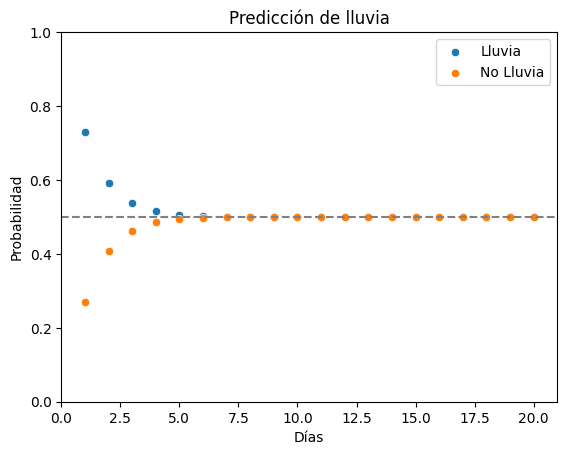

In [3]:
# Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear Dataframe
df = pd.DataFrame({"Días": range(1,num_dias_prediccion+1),
                   "Lluvia": [prob_sig_dias[dia][0] for dia in range(num_dias_prediccion)],
                   "NoLluvia": [prob_sig_dias[dia][1] for dia in range(num_dias_prediccion)]})

# Plot
sns.scatterplot(data=df, x="Días", y="Lluvia", label="Lluvia")
sns.scatterplot(data=df, x="Días", y="NoLluvia", label="No Lluvia")
# Agregar Linea de Equilibrio
plt.axhline(y = 0.5, color = 'gray', linestyle = '--')
# Etiquetas
plt.title("Predicción de lluvia")
plt.xlabel("Días")
plt.ylabel("Probabilidad")
# Ejes
plt.xlim(0, num_dias_prediccion+1)
plt.ylim(0, 1)
# Mostrar
plt.show()